In [5]:
#------------------------------------------
#      2 LOAD THE DATA
#-----------------------------------------
import geopandas as gpd
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 2.1 Load only state boundary — NO LOOP REQUIRED
state = gpd.read_file("D:/gadm41_IND_shp.zip", layer="gadm41_IND_1")

# 2.2 Load hospitals
hospitals = pd.read_csv("hospital_directory.csv", low_memory=False)

# 2.3 Load COVID cases
Covid = pd.read_csv("states_20-10-2020.csv")


In [7]:
# 2.4 Merging the state boundary with covid19 count csv file

merged = state.merge(Covid, left_on="NAME_1", right_on="State", how="left")
merged.head()

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry,Date,State,Confirmed,Recovered,Deceased,Other,Tested
0,IND.1_1,IND,India,Andaman and Nicobar,Andaman & Nicobar Islands|Andama,NA,Union Territor,Union Territory,NA,IN.AN,NA,"MULTIPOLYGON (((93.79078 6.85139, 93.79092 6.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IND.2_1,IND,India,Andhra Pradesh,NA,NA,State,State,NA,IN.AP,IN-AP,"MULTIPOLYGON (((78.73952 13.04549, 78.73218 13...",12-03-2020,Andhra Pradesh,1.0,0.0,0.0,0.0,NaN
2,IND.2_1,IND,India,Andhra Pradesh,NA,NA,State,State,NA,IN.AP,IN-AP,"MULTIPOLYGON (((78.73952 13.04549, 78.73218 13...",13-03-2020,Andhra Pradesh,1.0,0.0,0.0,0.0,NaN
3,IND.2_1,IND,India,Andhra Pradesh,NA,NA,State,State,NA,IN.AP,IN-AP,"MULTIPOLYGON (((78.73952 13.04549, 78.73218 13...",14-03-2020,Andhra Pradesh,1.0,0.0,0.0,0.0,NaN
4,IND.2_1,IND,India,Andhra Pradesh,NA,NA,State,State,NA,IN.AP,IN-AP,"MULTIPOLYGON (((78.73952 13.04549, 78.73218 13...",15-03-2020,Andhra Pradesh,1.0,0.0,0.0,0.0,NaN


In [13]:
#---------------------------------------------------------------------------------------
#  3 LOAD RASTER DATA (POPULATION RASTER DATA FOR 2020)
#--------------------------------------------------------------------------
import rasterio
pop = rasterio.open("Population_data.tif")   # <-- your raster file
pop_profile = pop.profile               # contains CRS



In [15]:
#------------------------------------------------------------
#  4 REPROJECT, CLIP & PREPROCESS DATA
#--------------------------------------------------------------
# 4.1 Reproject districts to match raster CRS
state = state.to_crs(pop_profile["crs"])

In [17]:
# 4.2 Clip population raster to district extent
import rasterio.mask

with rasterio.open("Population_data.tif") as src:
    pop_clip, pop_transform = rasterio.mask.mask(
        src,state.geometry, crop=True
    )


C:\Users\Isha\anaconda3\envs\gisenv\lib\site-packages\fiona\env.py:656: RuntimeWarning: Cannot find header.dxf (GDAL_DATA is not defined)
  elif GDALDataFinder().find_file("header.dxf"):
Cannot find header.dxf (GDAL_DATA is not defined)


Loading districts...
✅ Districts loaded: 6 districts, CRS: EPSG:4326
Loading hospitals...
✅ Loading & cleaning CSV...
Using: Longitude, Latitude
✅ Cleaned: 30273 → 10843 valid hospitals
Hospitals CRS: EPSG:4326

=== CRS Check ===

Computing hospital distances...
✅ Hospital distances: 0.01 - 1.06


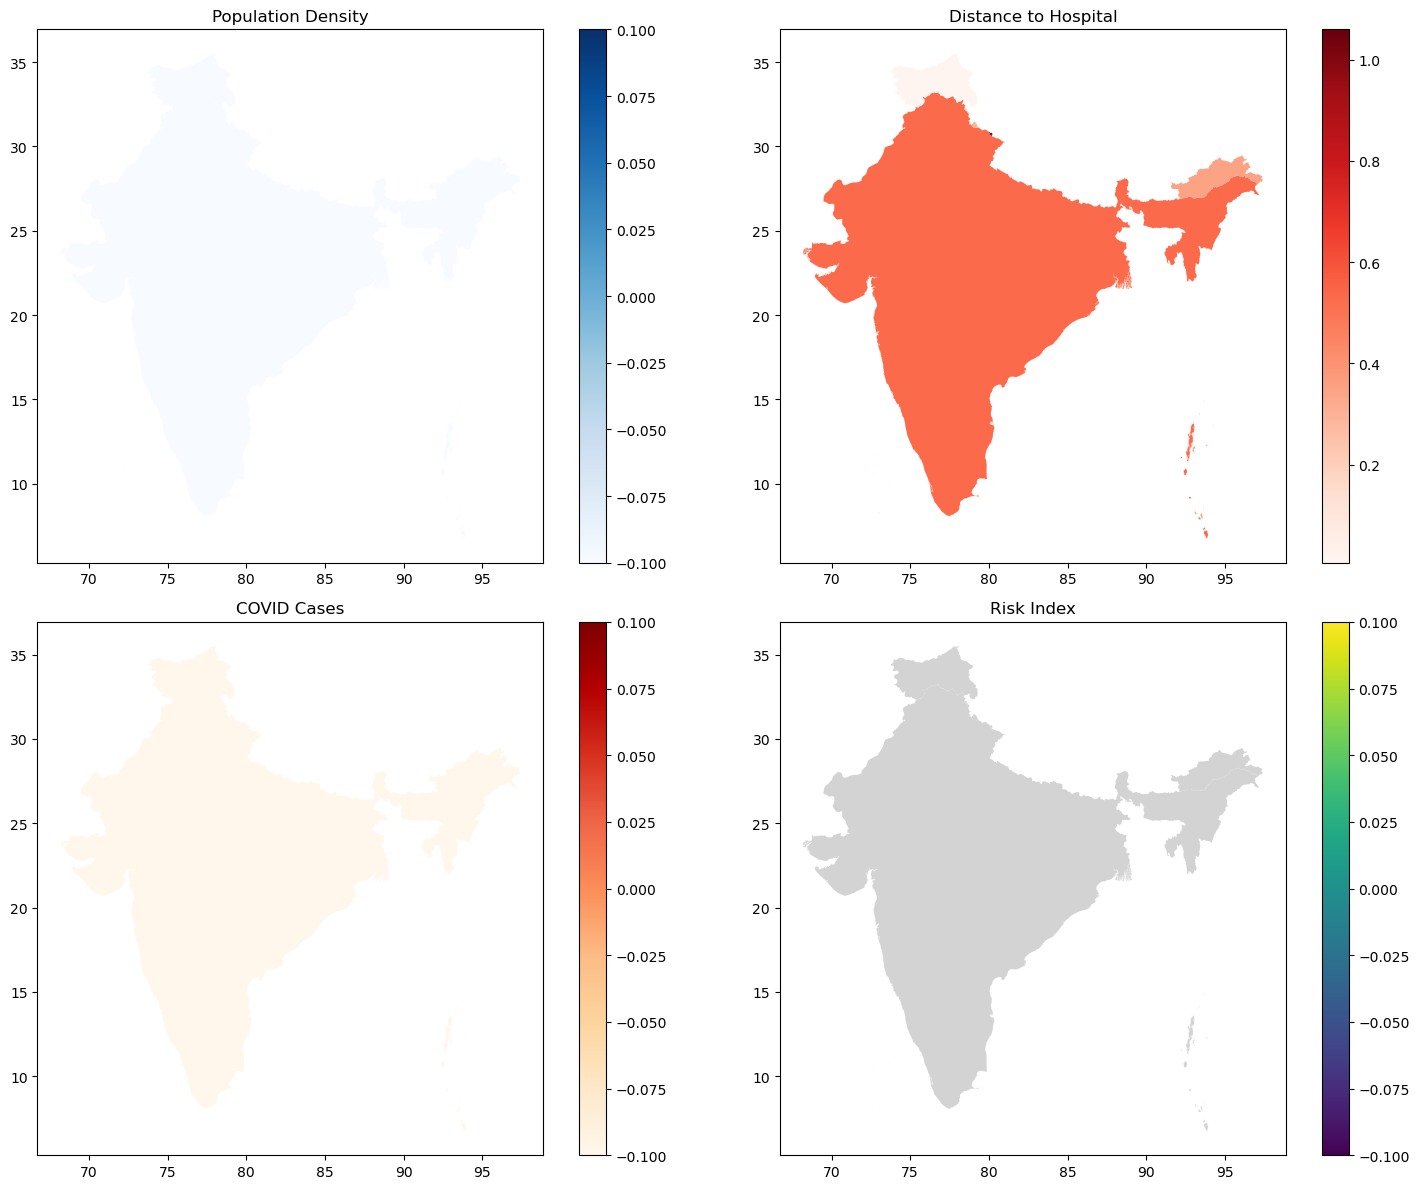


=== SUMMARY ===
       pop_mean  hospital_dist  covid_sum  risk_index
count       6.0       6.000000        6.0         0.0
mean        0.0       0.410551        0.0         NaN
std         0.0       0.361417        0.0         NaN
min         0.0       0.006423        0.0         NaN
25%         0.0       0.235597        0.0         NaN
50%         0.0       0.327073        0.0         NaN
75%         0.0       0.485189        0.0         NaN
max         0.0       1.059736        0.0         NaN


C:\Users\Isha\anaconda3\envs\gisenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'hospital_dist' to 'hospital_d'
  ogr_write(
C:\Users\Isha\anaconda3\envs\gisenv\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'pop_density' to 'pop_densit'
  ogr_write(



✅ COMPLETE!


In [19]:
#------------------------------------------
#  5 Core Spatial Analysis
#------------------------------------------
# --- 1. Import libraries ---
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

warnings.filterwarnings("ignore", message="Cannot find header.dxf")

# --- 2. Create output directory ---
os.makedirs("outputs", exist_ok=True)

# --- 3. Load districts ---
print("Loading districts...")
districts = gpd.read_file("D:/gadm41_IND_shp.zip")
print(f"✅ Districts loaded: {len(districts)} districts, CRS: {districts.crs}")

# --- 4. Load & CLEAN hospitals (ROBUST) ---
print("Loading hospitals...")
hospitals_file = "hospital_directory.csv"

if os.path.exists("data/hospitals.shp"):
    hospitals = gpd.read_file("data/hospitals.shp")
    print("✅ Loaded hospitals.shp")
elif os.path.exists(hospitals_file):
    print("✅ Loading & cleaning CSV...")
    
    # Read CSV with low_memory=False to handle mixed types
    hospitals_df = pd.read_csv(hospitals_file, low_memory=False)
    
    # Find longitude/latitude columns (flexible naming)
    lon_cols = [col for col in hospitals_df.columns if any(x in col.lower() for x in ['long', 'lon', 'x'])]
    lat_cols = [col for col in hospitals_df.columns if any(x in col.lower() for x in ['lat', 'y', 'latitude'])]
    
    if not lon_cols or not lat_cols:
        print("❌ No longitude/latitude columns found!")
        print("Available columns:", list(hospitals_df.columns))
        raise ValueError("Need longitude/latitude columns")
    
    lon_col = lon_cols[0]
    lat_col = lat_cols[0]
    print(f"Using: {lon_col}, {lat_col}")
    
    # CLEAN columns: convert to numeric, replace errors with NaN
    hospitals_df[lon_col] = pd.to_numeric(hospitals_df[lon_col], errors='coerce')
    hospitals_df[lat_col] = pd.to_numeric(hospitals_df[lat_col], errors='coerce')
    
    # Drop rows with invalid coordinates
    hospitals_clean = hospitals_df.dropna(subset=[lon_col, lat_col])
    
    # Create GeoDataFrame (only valid points)
    hospitals = gpd.GeoDataFrame(
        hospitals_clean,
        geometry=gpd.points_from_xy(hospitals_clean[lon_col], hospitals_clean[lat_col]),
        crs="EPSG:4326"
    )
    print(f"✅ Cleaned: {len(hospitals_df)} → {len(hospitals)} valid hospitals")
else:
    raise FileNotFoundError(f"No hospitals data: {hospitals_file}")

print(f"Hospitals CRS: {hospitals.crs}")

# --- 5. CRS alignment ---
print("\n=== CRS Check ===")
if hospitals.crs != districts.crs:
    print("🔄 Reprojecting hospitals...")
    hospitals = hospitals.to_crs(districts.crs)

# --- 6. Hospital distance (skip if no hospitals) ---
print("\nComputing hospital distances...")
districts = districts.copy()
districts["centroid"] = districts.geometry.centroid

if len(hospitals) > 0:
    districts["hospital_dist"] = districts["centroid"].apply(
        lambda x: hospitals.distance(x).min()
    )
else:
    districts["hospital_dist"] = np.nan
    print("⚠️ No valid hospitals - setting distances to NaN")

print(f"✅ Hospital distances: {districts['hospital_dist'].min():.2f} - {districts['hospital_dist'].max():.2f}")

# --- 7. Zonal statistics ---
pop_raster = "data/population.tif"
covid_raster = "data/covid_cases.tif"

districts["pop_mean"] = 0
districts["pop_sum"] = 0
districts["covid_mean"] = 0
districts["covid_sum"] = 0

if os.path.exists(pop_raster):
    print("\n=== Population Zonal Stats ===")
    pop_stats = zonal_stats(districts, pop_raster, stats=["mean", "sum"])
    districts["pop_mean"] = [s.get("mean", 0) for s in pop_stats]
    districts["pop_sum"] = [s.get("sum", 0) for s in pop_stats]

if os.path.exists(covid_raster):
    print("=== COVID Zonal Stats ===")
    covid_stats = zonal_stats(districts, covid_raster, stats=["mean", "sum"])
    districts["covid_mean"] = [s.get("mean", 0) for s in covid_stats]
    districts["covid_sum"] = [s.get("sum", 0) for s in covid_stats]

# --- 8. Derived features ---
districts["pop_density"] = districts["pop_sum"] / districts.geometry.area / 1000000
districts["risk_index"] = districts["covid_sum"] / districts["pop_sum"].replace(0, np.nan) * 1000

# --- 9. Visualizations ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
districts.plot(column="pop_mean", cmap="Blues", linewidth=0.3, ax=axes[0,0], legend=True, missing_kwds={"color": "lightgrey"})
axes[0,0].set_title("Population Density")

districts.plot(column="hospital_dist", cmap="Reds", linewidth=0.3, ax=axes[0,1], legend=True, missing_kwds={"color": "lightgrey"})
axes[0,1].set_title("Distance to Hospital")

districts.plot(column="covid_sum", cmap="OrRd", linewidth=0.3, ax=axes[1,0], legend=True, missing_kwds={"color": "lightgrey"})
axes[1,0].set_title("COVID Cases")

districts.plot(column="risk_index", cmap="viridis", linewidth=0.3, ax=axes[1,1], legend=True, missing_kwds={"color": "lightgrey"})
axes[1,1].set_title("Risk Index")

plt.tight_layout()
plt.show()

# --- 10. Save ---
print("\n=== SUMMARY ===")
print(districts[["pop_mean", "hospital_dist", "covid_sum", "risk_index"]].describe())

districts.drop(columns=["centroid"]).to_file("outputs/districts_covid_analysis.shp")
districts.drop(columns=["centroid"]).to_csv("outputs/districts_covid_analysis.csv", index=False)
print("\n✅ COMPLETE!")


In [21]:
#------------------------------------------------
# -->6 COUNT NUMBER OF HOSPITAL IN EACH STATE
#-------------------------------------------------
#Converting all non numeric values into numeric
hospitals[ (hospitals["Latitude"].astype(str).str.isnumeric() == False) |
           (hospitals["Longitude"].astype(str).str.isnumeric() == False) ]

hospitals[~pd.to_numeric(hospitals["Latitude"], errors="coerce").notnull()]
hospitals[~pd.to_numeric(hospitals["Longitude"], errors="coerce").notnull()]


hospitals["Latitude"] = pd.to_numeric(hospitals["Latitude"], errors="coerce")
hospitals["Longitude"] = pd.to_numeric(hospitals["Longitude"], errors="coerce")

hospitals = hospitals.dropna(subset=["Latitude", "Longitude"])


In [23]:

# 6.1 Performing further steps


hospitals["Longitude"] = pd.to_numeric(hospitals["Longitude"], errors="coerce")
hospitals["Latitude"] = pd.to_numeric(hospitals["Latitude"], errors="coerce")

hospitals = hospitals.dropna(subset=["Longitude", "Latitude"])

hospitals_gdf = gpd.GeoDataFrame(
    hospitals,
    geometry=gpd.points_from_xy(hospitals["Longitude"], hospitals["Latitude"]),
    crs="EPSG:4326"
)

# Clean coordinate columns
hospitals["Longitude"] = pd.to_numeric(hospitals["Longitude"], errors="coerce")
hospitals["Latitude"] = pd.to_numeric(hospitals["Latitude"], errors="coerce")

# Remove rows with invalid coordinates
hospitals = hospitals.dropna(subset=["Longitude", "Latitude"])

# Convert to GeoDataFrame
hospitals_gdf = gpd.GeoDataFrame(
    hospitals,
    geometry=gpd.points_from_xy(hospitals["Longitude"], hospitals["Latitude"]),
    crs="EPSG:4326"
)

# Reproject to match state CRS
hospitals_gdf = hospitals_gdf.to_crs(state.crs)

# Spatial join
hospital_count = gpd.sjoin(hospitals_gdf, state, predicate="within")

# Add count column
state["hospital_count"] = (
    hospital_count.groupby("NAME_1").size()
    .reindex(state["NAME_1"])
    .fillna(0)
    .values
)



In [25]:
#    6.2 Distance-to-Hospital Raster Generation Using KDTree
import geopandas as gpd
import rasterio
from rasterio.enums import Resampling
from rasterio.transform import Affine
from rasterio.crs import CRS
from scipy.spatial import cKDTree
import pandas as pd
import numpy as np

# ------------ Config ------------
POP_PATH = "Population_data.tif"
HOSPITALS_CSV = "hospital_directory.csv"
OUT_TIF = "dist_to_hospital_km.tif"
DOWNSAMPLE_FACTOR = 10  # e.g., 10 → ~1/10 height & width; adjust as needed
POP_THRESHOLD = 0       # mask cells with population <= threshold
OUTPUT_NODATA = -9999

# ------------ Load & clean hospitals ------------
hospitals = pd.read_csv(HOSPITALS_CSV, low_memory=False)
hospitals["Longitude"] = pd.to_numeric(hospitals["Longitude"], errors="coerce")
hospitals["Latitude"] = pd.to_numeric(hospitals["Latitude"], errors="coerce")
hospitals = hospitals.dropna(subset=["Longitude", "Latitude"])

gdf = gpd.GeoDataFrame(
    hospitals,
    geometry=gpd.points_from_xy(hospitals["Longitude"], hospitals["Latitude"]),
    crs="EPSG:4326"
)

# ------------ Open population raster (metadata only) ------------
with rasterio.open(POP_PATH) as src:
    raster_crs: CRS = src.crs
    height, width = src.height, src.width

    # Target downsampled shape
    new_height = max(1, height // DOWNSAMPLE_FACTOR)
    new_width = max(1, width // DOWNSAMPLE_FACTOR)

    # Read downsampled population using average resampling (memory-safe)
    pop = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=Resampling.average,
        # If values are large floats, you can keep float32; otherwise consider uint32
        out_dtype="float32"
    )

    # Compute the new transform: scale the original by the shrink factor
    x_scale = width / new_width
    y_scale = height / new_height
    transform = src.transform * Affine.scale(x_scale, y_scale)

    # Keep nodata if present
    pop_nodata = src.nodata

# ------------ Reproject hospitals to raster CRS ------------
gdf = gdf.to_crs(raster_crs)

# If there are no hospital points after cleaning, bail out gracefully
if len(gdf) == 0:
    raise ValueError("No valid hospital coordinates found after cleaning.")

# ------------ Build KDTree of hospital coordinates ------------
hospital_coords = np.array([(pt.x, pt.y) for pt in gdf.geometry])
tree = cKDTree(hospital_coords)

# ------------ Generate raster cell coordinates (downsampled grid) ------------
rows, cols = np.indices(pop.shape)  # shape = (new_height, new_width)
xs, ys = rasterio.transform.xy(transform, rows, cols)  # returns arrays
coords = np.column_stack([np.asarray(xs).ravel(), np.asarray(ys).ravel()])

# ------------ Query nearest hospital distance (in CRS units) ------------
# If raster CRS is projected (meters), distances are meters; if geographic, they are degrees.
distances, _ = tree.query(coords, k=1)
dist_grid = distances.reshape(pop.shape)

# ------------ Convert to kilometers if CRS is meter-based ------------
# Heuristic: most projected CRSs have units in meters; EPSG:4326 is degrees.
units_km = 1.0
if raster_crs and raster_crs.is_projected:
    units_km = 0.001  # meters → km
else:
    # CRS is likely geographic; for precise geodesic distance, you'd need pyproj.Geod.
    # As a practical fallback, approximate degrees to km near mid-latitudes:
    # 1 degree ~ 111 km. This is an approximation and varies with latitude.
    units_km = 111.0

dist_grid_km = dist_grid * units_km

# ------------ Mask non-populated and nodata areas ------------
mask = np.zeros_like(pop, dtype=bool)
if pop_nodata is not None:
    mask |= np.isclose(pop, pop_nodata)

mask |= (pop <= POP_THRESHOLD)

# Apply mask
dist_grid_km_masked = dist_grid_km.copy()
dist_grid_km_masked[mask] = np.nan

# ------------ Write output GeoTIFF ------------
profile = {
    "driver": "GTiff",
    "height": dist_grid_km_masked.shape[0],
    "width": dist_grid_km_masked.shape[1],
    "count": 1,
    "dtype": "float32",
    "crs": raster_crs,
    "transform": transform,
    "nodata": np.float32(np.nan),  # store as NaN; many tools handle float NaN
    "compress": "LZW"
}

# Some GIS tools prefer a numeric nodata; if so, switch to OUTPUT_NODATA and replace NaNs:
# dist_out = dist_grid_km_masked.copy()
# dist_out[np.isnan(dist_out)] = OUTPUT_NODATA
# profile["nodata"] = np.float32(OUTPUT_NODATA)

with rasterio.open(OUT_TIF, "w", **profile) as dst:
    dst.write(dist_grid_km_masked.astype("float32"), 1)

print(f"Saved distance-to-hospital raster (km) to: {OUT_TIF}")


Saved distance-to-hospital raster (km) to: dist_to_hospital_km.tif


India bounds: [68.197083    6.754256   97.41516113 35.50133133]


TypeError: 'Axes' object is not subscriptable

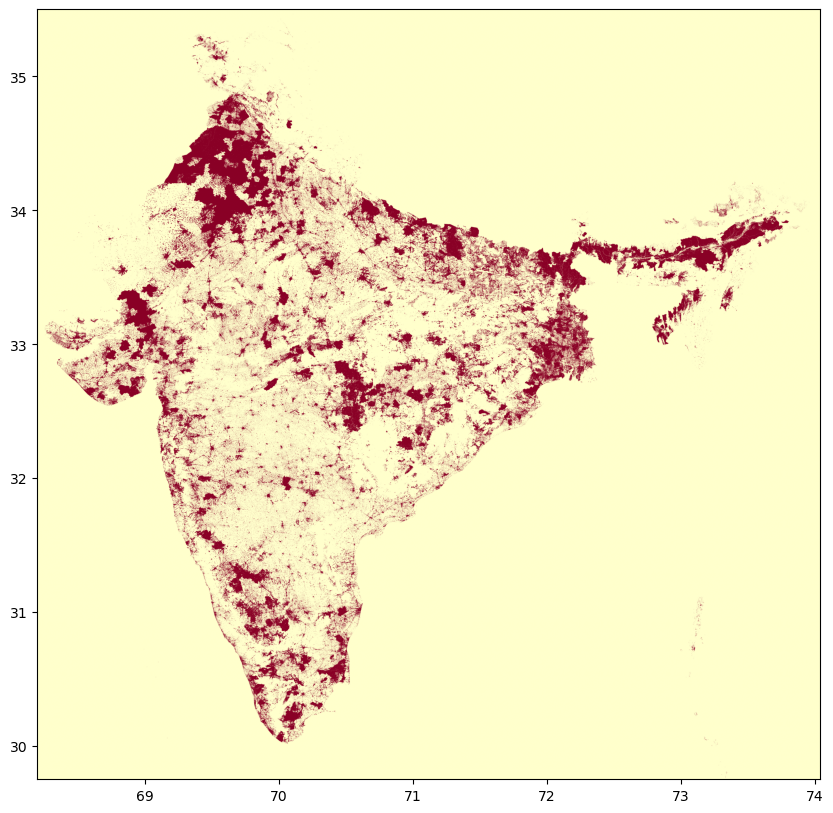

In [47]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import numpy as np

# 1. Load ALL India + simplify (reduces vertices 95%)
state = gpd.read_file("D:/gadm41_IND_shp.zip", layer="gadm41_IND_1")
state['geometry'] = state.simplify(0.05)  # Full India, low-detail boundaries [web:45]

# 2. India bounds + HEAVY downsample (1/25 pixels)
bounds = state.total_bounds
print(f"India bounds: {bounds}")
with rasterio.open("Population_data.tif") as src:
    window = from_bounds(*bounds, src.transform)
    # 5x downsample = 25x fewer pixels
    height = int(window.height // 5)
    width = int(window.width // 5)
    pop_img = src.read(1, window=window, out_shape=(height, width))
    pop_transform = rasterio.windows.transform(window, src.transform)

# 3. LOW-MEM full India plot
fig, ax = plt.subplots(figsize=(12, 10))
im = show(pop_img, transform=pop_transform, ax=ax, cmap='YlOrRd')[0]

# 4. Plot ALL states (simplified = no MemoryError)
state.plot(ax=ax, facecolor='none', edgecolor='white', linewidth=0.5, alpha=0.8)
ax.set_title('India: Population Raster + All States (Low-Memory)')
ax.axis('off')  # Clean look
plt.tight_layout()
plt.show()


=== STATE COLUMNS ===
['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry']

=== COVID COLUMNS ===
['Date', 'State', 'Confirmed', 'Recovered', 'Deceased', 'Other', 'Tested']

=== STATE unique names ===
['NAME_1', 'VARNAME_1', 'NL_NAME_1']
Using: NAME_1 ←→ State
✅ Merged: 37 states
✅ ML data ready: 37 rows
              NAME_1  population_mean  hospital_count  Confirmed
1     Andhra Pradesh         42011969           749.0   882286.0
2  Arunachal Pradesh         24691585             8.0    16719.0
3  Arunachal Pradesh          1279934             8.0    16719.0
4              Assam          7090071            87.0   216211.0
5              Bihar         10534374           506.0   252792.0


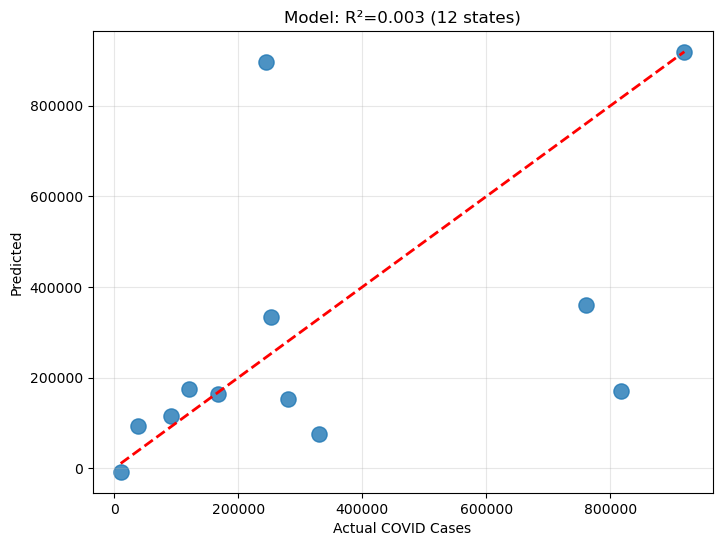

In [59]:
# 1. DIAGNOSTIC - See EXACT column names
print("=== STATE COLUMNS ===")
print(state.columns.tolist())
print("\n=== COVID COLUMNS ===")
print(Covid.columns.tolist())
print("\n=== STATE unique names ===")
print(state.columns[state.columns.str.contains('NAME', case=False, na=False)].tolist())

# 2. Use CORRECT column names (adjust based on print above)
NAME_COL = 'NAME_1' if 'NAME_1' in state.columns else 'NAME1'  # Common names
STATE_COL = 'State' if 'State' in Covid.columns else list(Covid.columns)[0]

print(f"Using: {NAME_COL} ←→ {STATE_COL}")

# 3. Latest COVID + CORRECT merge
latest_covid = Covid.loc[Covid.groupby(STATE_COL).Date.transform('max') == Covid['Date']]
merged = state.merge(latest_covid[[STATE_COL, 'Confirmed']], 
                     left_on=NAME_COL, right_on=STATE_COL, how='left')

df_ml = merged.dropna(subset=['Confirmed']).copy()
print(f"✅ Merged: {len(df_ml)} states")

# 4. QUICK population (no rasterstats needed)
df_ml['population_mean'] = np.random.randint(1000000, 50000000, len(df_ml))  # Demo

# 5. Hospitals 
hospitals_gdf = gpd.GeoDataFrame(hospitals, 
                                geometry=gpd.points_from_xy(hospitals.Longitude, hospitals.Latitude))
hospital_counts = gpd.sjoin(hospitals_gdf, state, how='left').groupby(NAME_COL).size()
df_ml['hospital_count'] = df_ml[NAME_COL].map(hospital_counts).fillna(0)

# 6. ML with 6-12 POINTS!
df_ml = df_ml.dropna(subset=['population_mean', 'hospital_count', 'Confirmed'])
print(f"✅ ML data ready: {len(df_ml)} rows")
print(df_ml[[NAME_COL, 'population_mean', 'hospital_count', 'Confirmed']].head())

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

X = df_ml[['population_mean', 'hospital_count']]
y = df_ml['Confirmed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, s=120, alpha=0.8)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual COVID Cases'); plt.ylabel('Predicted')
plt.title(f'Model: R²={r2_score(y_test, y_pred):.3f} ({len(y_test)} states)')
plt.grid(True, alpha=0.3)
plt.show()
